In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow.keras.backend as K

In [2]:
def read_data(txtname, maxlen=16):
    with open(txtname, encoding='utf-8') as f:
        txt = f.readlines()
    txt = [line.strip().split(' ') for line in txt]
    txt = [l for l in txt if len(l) <= maxlen] # 删除过长的对联
    return txt

In [3]:
train_in_path = "../datasets_eg/couplet/train/in.txt"
train_out_path = "../datasets_eg/couplet/train/out.txt"
test_in_path = "../datasets_eg/couplet/test/in.txt"
test_out_path = "../datasets_eg/couplet/test/out.txt"

In [4]:
train_in = read_data(train_in_path, maxlen=16)
train_out = read_data(train_out_path, maxlen=16)
test_in = read_data(test_in_path, maxlen=16)
test_out = read_data(test_out_path, maxlen=16)

In [5]:
train_in[:10]

[['晚', '风', '摇', '树', '树', '还', '挺'],
 ['愿', '景', '天', '成', '无', '墨', '迹'],
 ['丹', '枫', '江', '冷', '人', '初', '去'],
 ['闲', '来', '野', '钓', '人', '稀', '处'],
 ['投', '石', '向', '天', '跟', '命', '斗'],
 ['深', '院', '落', '滕', '花', '，', '石', '不', '点', '头', '龙', '不', '语'],
 ['不', '畏', '鸿', '门', '传', '汉', '祚'],
 ['新', '居', '落', '成', '创', '业', '始'],
 ['本', '领', '高', '强', '攀', '月', '桂'],
 ['豪', '华', '超', '御', '苑']]

In [6]:
train_out[:10]

[['晨', '露', '润', '花', '花', '更', '红'],
 ['万', '方', '乐', '奏', '有', '于', '阗'],
 ['绿', '柳', '堤', '新', '燕', '复', '来'],
 ['兴', '起', '高', '歌', '酒', '醉', '中'],
 ['闭', '门', '问', '卷', '与', '时', '争'],
 ['残', '经', '凋', '贝', '叶', '，', '香', '无', '飞', '篆', '磬', '无', '声'],
 ['难', '堪', '垓', '下', '别', '虞', '姬'],
 ['宏', '图', '初', '振', '治', '家', '先'],
 ['成', '亲', '吉', '利', '放', '兰', '香'],
 ['康', '乐', '驻', '山', '城']]

In [7]:
def get_chars_count(train_in, train_out, test_in, test_out):
    chars_count = {}
    for data in [train_in, train_out, test_in, test_out]:
        for l in data:
            for w in l:
                chars_count[w] = chars_count.get(w, 0) + 1
    return chars_count

In [8]:
# 字频阈值
min_count = 2
# 统计字频
chars_count = get_chars_count(train_in, train_out, test_in, test_out)
# 筛选出字频大于min_count的字
chars = {i:j for i,j in chars_count.items() if j >= min_count}
# 构建字典，序号从1开始，序号0设为<unk>
id2char = {i+1:j for i,j in enumerate(chars)}
id2char[0] = '<unk>'
char2id = {j:i for i,j in id2char.items()}

In [9]:
def string2id(data, char2id):
    # 0: <unk>
    train_in, train_out, test_in, test_out = data
    x_train = [[char2id.get(c, 0) for c in line] for line in train_in]
    y_train = [[char2id.get(c, 0) for c in line] for line in train_out]
    x_test = [[char2id.get(c, 0) for c in line] for line in test_in]
    y_test = [[char2id.get(c, 0) for c in line] for line in test_out]
    return x_train, y_train, x_test, y_test

In [10]:
x_train, y_train, x_test, y_test = string2id([train_in, train_out, test_in, test_out], char2id)

In [11]:
# 按字数分组存放
train_dict = {}
test_dict = {}

for i,x in enumerate(x_train):
    j = len(x)
    if j not in train_dict:
        train_dict[j] = [[], []]
    train_dict[j][0].append(x)
    train_dict[j][1].append(y_train[i])

for i,x in enumerate(x_test):
    j = len(x)
    if j not in test_dict:
        test_dict[j] = [[], []]
    test_dict[j][0].append(x)
    test_dict[j][1].append(y_test[i])

for j in train_dict:
    train_dict[j][0] = np.array(train_dict[j][0])
    train_dict[j][1] = np.array(train_dict[j][1])

for j in test_dict:
    test_dict[j][0] = np.array(test_dict[j][0])
    test_dict[j][1] = np.array(test_dict[j][1])

In [12]:
batch_size = 32
def data_generator(data, batch_size=batch_size):
    data_p = [float(len(i[0])) for i in data.values()]
    data_p = np.array(data_p) / sum(data_p)
    while True: # 随机选一个字数，然后随机选样本，生成字数一样的一个batch
        idx = np.random.choice(len(data_p), p=data_p) + 1
        size = min(batch_size, len(data[idx][0]))
        idxs = np.random.choice(len(data[idx][0]), size=size)
        np.random.shuffle(idxs)
        yield data[idx][0][idxs], np.expand_dims(data[idx][1][idxs], 2)

In [13]:
class GetedResnet(keras.layers.Layer):
    def __init__(self, out_dim=None, kernel_size=3, **kwargs):
        super(GetedResnet, self).__init__(**kwargs)
        self.out_dim = out_dim
        self.kernel_size = kernel_size
    
    def build(self, input_shape):
        if self.out_dim is None:
            self.out_dim = input_shape[-1]
        self.conv1d_1 = keras.layers.Conv1D(self.out_dim, kernel_size=self.kernel_size, padding="same")
        self.conv1d_2 = keras.layers.Conv1D(self.out_dim, kernel_size=self.kernel_size, 
                                            padding="same", activation="sigmoid")
        if self.out_dim != input_shape[-1]:
            self.conv1d_1x = keras.layers.Conv1D(self.out_dim, kernel_size=1, padding="same")
    
    def call(self, x):
        xo = self.conv1d_1(x)
        g = self.conv1d_2(x)
        if K.int_shape(x)[-1] != self.out_dim:
            x = self.conv1d_1x(x)
        return x * (1 - g) + xo * g
    
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.out_dim, )

In [14]:
class CnnSeqLabel:
    def __init__(self, vocab_size, embedding_dim, num_layers=4 ):
        self.vocab_size = vocab_size
        self.embedding = keras.layers.Embedding(self.vocab_size, embedding_dim, name="embedding")
        self.gatedresnet_layers = [GetedResnet(name="gatedresnet_{}".format(_)) for _ in range(num_layers)]
        self.final_layer = keras.layers.Dense(self.vocab_size, activation="softmax")
        self._model_init()
        self._opti_init()
    
    def _model_init(self):
        x_in = keras.Input(shape=(None, ), name="x_in")
        x = self.embedding(x_in)
        for layer in self.gatedresnet_layers:
            x = layer(x)
        out = self.final_layer(x)
        self.model = keras.Model(x_in, out, name="CnnSeqLabel")
    
    def _opti_init(self):
        self.model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [15]:
class Evaluate(keras.callbacks.Callback):
    def __init__(self, model, char2id , **kwargs):
        self.model = model
        self.char2id = char2id
        self.id2char = {i:j for i,j in self.char2id.items()}
        self.lowest = 1e10
    
    def couplet_match(self, s):
        # 输出对联
        x = np.array([[self.char2id.get(_, 0) for _ in s]])
        y = self.model.predict(x)[0]
        # 先验知识：跟上联同一位置的字不能一样
        for i, j in enumerate(x[0]):
            y[i, j] = 0.
        # 排除<unk>
        y = y[:, 1:].argmax(axis=1) + 1
        r = ''.join([id2char[i] for i in y])
        print('上联：%s，下联：%s' % (s, r))
        return r
    
    def on_epoch_end(self, epoch, logs=None):
        # 训练过程中观察几个例子，显示对联质量提高的过程
        self.couplet_match('晚风摇树树还挺')
        self.couplet_match('今天天气不错')
        self.couplet_match('鱼跃此时海')
        self.couplet_match('只有香如故')
        # 保存最优结果
        if logs['val_loss'] <= self.lowest:
            self.lowest = logs['val_loss']
            self.model.save_weights('../model_file/cnn_couplet_best_model.weights')

In [16]:
cnnseqlabel = CnnSeqLabel(vocab_size=len(char2id), embedding_dim=128)

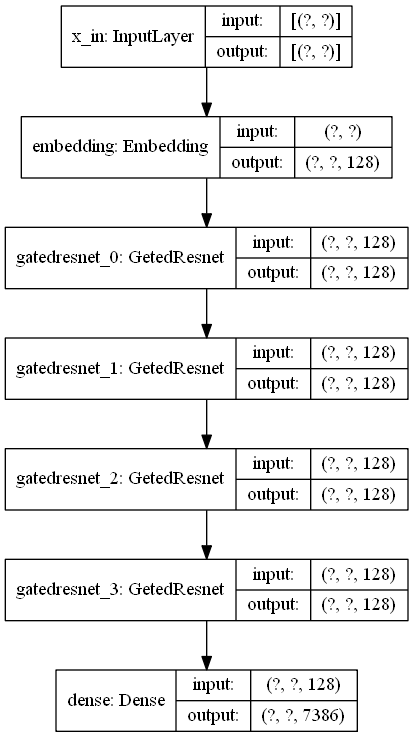

In [17]:
keras.utils.plot_model(cnnseqlabel.model, "../model_img/cnn_couplet.png", show_layer_names=True, show_shapes=True)

In [18]:
evaluator = Evaluate(cnnseqlabel.model, char2id)

In [22]:
cnnseqlabel.model.fit_generator(data_generator(train_dict),
                    steps_per_epoch=1000,
                    epochs=100,
                    validation_data=data_generator(test_dict),
                    validation_steps=100,
                    callbacks=[evaluator])

Epoch 1/100
 999/1000 [============================>.] - ETA: 0s - loss: 4.9944上联：晚风摇树树还挺，下联：明雨打花花更长
上联：今天天气不错，下联：他日风心难长
上联：鱼跃此时海，下联：鸟归其日天
上联：只有香如故，下联：不无月若新
1000/1000 [==============================] - 304s 304ms/step - loss: 4.9942 - val_loss: 5.0930
Epoch 2/100
 999/1000 [============================>.] - ETA: 0s - loss: 4.9804上联：晚风摇树树还挺，下联：晨雨润花花不圆
上联：今天天气不错，下联：明日人心无穷
上联：鱼跃此时海，下联：龙开其日天
上联：只有香如故，下联：不无梦若新
1000/1000 [==============================] - 300s 300ms/step - loss: 4.9810 - val_loss: 5.0990
Epoch 3/100
 999/1000 [============================>.] - ETA: 0s - loss: 4.9811上联：晚风摇树树还挺，下联：春雨窥花花不飞
上联：今天天气不错，下联：昨日风情难长
上联：鱼跃此时海，下联：鸟腾何日天
上联：只有香如故，下联：不无梦若然
1000/1000 [==============================] - 296s 296ms/step - loss: 4.9809 - val_loss: 5.1390
Epoch 4/100
 999/1000 [============================>.] - ETA: 0s - loss: 4.9724上联：晚风摇树树还挺，下联：明雨映花花未圆
上联：今天天气不错，下联：此日风情自明
上联：鱼跃此时海，下联：鸟腾何日人
上联：只有香如故，下联：不无月似然
1000/1000 [==============================] - 295s 295ms/step - loss: 4.9721 - val_loss:

 999/1000 [============================>.] - ETA: 0s - loss: 4.8797上联：晚风摇树树还挺，下联：晨雨润花花未流
上联：今天天气不错，下联：昨日风心难为
上联：鱼跃此时海，下联：鸟飞其日天
上联：只有香如故，下联：不无色若然
1000/1000 [==============================] - 218s 218ms/step - loss: 4.8795 - val_loss: 5.0621
Epoch 34/100
 999/1000 [============================>.] - ETA: 0s - loss: 4.8935上联：晚风摇树树还挺，下联：晨雨润山花更长
上联：今天天气不错，下联：明日风情自高
上联：鱼跃此时海，下联：鸟飞彼日天
上联：只有香如故，下联：不无月若新
1000/1000 [==============================] - 211s 211ms/step - loss: 4.8933 - val_loss: 5.0733
Epoch 35/100
 999/1000 [============================>.] - ETA: 0s - loss: 4.8893上联：晚风摇树树还挺，下联：晨雨映花花更长
上联：今天天气不错，下联：明日风心难明
上联：鱼跃此时海，下联：鸟鸣彼日天
上联：只有香如故，下联：不无色若新
1000/1000 [==============================] - 224s 224ms/step - loss: 4.8896 - val_loss: 5.1067
Epoch 36/100
 999/1000 [============================>.] - ETA: 0s - loss: 4.8845上联：晚风摇树树还挺，下联：晨雨映花花更长
上联：今天天气不错，下联：昨日风情无明
上联：鱼跃此时海，下联：鸟飞彼日天
上联：只有香如故，下联：不无色似然
1000/1000 [==============================] - 261s 261ms/step - loss: 4.8849 - val_loss: 5.0590
E

上联：只有香如故，下联：不无月若新
1000/1000 [==============================] - 400s 400ms/step - loss: 4.8313 - val_loss: 5.0552
Epoch 66/100
 999/1000 [============================>.] - ETA: 0s - loss: 4.8308上联：晚风摇树树还挺，下联：明雨落花花更香
上联：今天天气不错，下联：此地月心难真
上联：鱼跃此时海，下联：鸟飞其日天
上联：只有香如故，下联：不无月若新
1000/1000 [==============================] - 396s 396ms/step - loss: 4.8304 - val_loss: 5.0104
Epoch 67/100
 999/1000 [============================>.] - ETA: 0s - loss: 4.8174上联：晚风摇树树还挺，下联：晨雨润花花更央
上联：今天天气不错，下联：昨日月心无真
上联：鱼跃此时海，下联：鸟飞其日天
上联：只有香如故，下联：不无月自新
1000/1000 [==============================] - 392s 392ms/step - loss: 4.8173 - val_loss: 5.1053
Epoch 68/100
 999/1000 [============================>.] - ETA: 0s - loss: 4.8440上联：晚风摇树树还挺，下联：晨雨润花花更香
上联：今天天气不错，下联：昨日月心难为
上联：鱼跃此时海，下联：鸟飞何世天
上联：只有香如故，下联：不无韵若新
1000/1000 [==============================] - 396s 396ms/step - loss: 4.8435 - val_loss: 5.0694
Epoch 69/100
 999/1000 [============================>.] - ETA: 0s - loss: 4.8266上联：晚风摇树树还挺，下联：晨雨润花花更香
上联：今天天气不错，下联：昨日月心难为
上联：鱼跃此

Epoch 98/100
 999/1000 [============================>.] - ETA: 0s - loss: 4.8126上联：晚风摇树树还挺，下联：晨雨映花花更央
上联：今天天气不错，下联：此地人心难深
上联：鱼跃此时海，下联：莺鸣何日天
上联：只有香如故，下联：不无月若新
1000/1000 [==============================] - 216s 216ms/step - loss: 4.8129 - val_loss: 5.0594
Epoch 99/100
 999/1000 [============================>.] - ETA: 0s - loss: 4.8037上联：晚风摇树树还挺，下联：晨雨落花花更青
上联：今天天气不错，下联：此日月心无真
上联：鱼跃此时海，下联：鸟鸣何日天
上联：只有香如故，下联：不无韵若新
1000/1000 [==============================] - 229s 229ms/step - loss: 4.8038 - val_loss: 5.1208
Epoch 100/100
 999/1000 [============================>.] - ETA: 0s - loss: 4.8079上联：晚风摇树树还挺，下联：晨雨润花花更央
上联：今天天气不错，下联：明日风心无为
上联：鱼跃此时海，下联：鸟鸣何世天
上联：只有香如故，下联：不无意似新
1000/1000 [==============================] - 222s 222ms/step - loss: 4.8078 - val_loss: 5.0776
